## 0. Import

In [17]:
import os
import cv2
import joblib
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from spectral import open_image
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

## 1. 데이터 준비

In [18]:
def prepare_data(splited_folder, splited_label_folder):
    """Load and preprocess data from folders."""
    data, labels = [], []

    for file in os.listdir(splited_label_folder):
        if file.endswith('.png'):
            label_path = os.path.join(splited_label_folder, file)
            hdr_path = os.path.join(splited_folder, file.replace('.png', '.hdr'))

            if os.path.exists(hdr_path):
                # Load hyperspectral data
                img = open_image(hdr_path)
                hyperspectral_data = img.load()
                data.append(hyperspectral_data.reshape(-1, hyperspectral_data.shape[-1]))

                # Load and flatten label image with custom mapping
                label_img = Image.open(label_path).convert('L')
                label_array = np.array(label_img).flatten()
                label_array = np.where(label_array < 15, 0, np.where(label_array > 240, 255, 128))
                labels.append(label_array)

    return np.vstack(data), np.hstack(labels)


In [ ]:
# Paths
splited_folder = r"Z:\5. 연구소\2. 국책과제\2023-기술혁신-시장대응형(스마트APC)\참고자료2024 자체 구축 데이터셋\사과\241205 사과 당도\splited"
splited_label_folder = r"Z:\5. 연구소\2. 국책과제\2023-기술혁신-시장대응형(스마트APC)\참고자료\2024 자체 구축 데이터셋\사과\241205 사과 당도\splited_label"

# Load data and labels
data, labels = prepare_data(splited_folder, splited_label_folder)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

## 2. 모델 학습

In [20]:
# 학습 진행 여부 선택택
do_train = True

In [ ]:
if do_train:
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    joblib.dump(rf_model, "./weights/apple_random_forest_model.pkl")

In [ ]:
if do_train:
    rf_model_diff = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model_diff.fit(np.diff(X_train, axis=1), y_train)
    joblib.dump(rf_model_diff, "./weights/apple_random_forest_diff_model.pkl")

## 3. 모델 평가

In [ ]:
# Evaluate models
print("Normal Model Classification Report:")

# 저장된 모델 불러오기
rf_model = joblib.load("./weights/apple_random_forest_model.pkl")
print(X_test.shape)
y_pred1 = rf_model.predict(X_test)
print(classification_report(y_test, y_pred1))


Normal Model Classification Report:
(102960, 256)
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     54831
         128       0.99      0.75      0.85       640
         255       0.98      0.98      0.98     47489

    accuracy                           0.98    102960
   macro avg       0.99      0.90      0.94    102960
weighted avg       0.98      0.98      0.98    102960



In [ ]:
# Evaluate models
print("Diff' Model Classification Report:")

# 저장된 모델 불러오기
rf_model_diff = joblib.load("./weights/apple_random_forest_diff_model.pkl")
print(np.diff(X_test, axis=-1).shape)
y_pred2 = rf_model_diff.predict(np.diff(X_test, axis=-1))
print(classification_report(y_test, y_pred2))


Diff' Model Classification Report:
(102960, 255)
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     54831
         128       1.00      0.00      0.01       640
         255       0.97      0.96      0.97     47489

    accuracy                           0.97    102960
   macro avg       0.98      0.65      0.65    102960
weighted avg       0.97      0.97      0.97    102960



## 4. 시각화

In [25]:
def normalize_band(band):
    """Normalize a band to the range 0-255."""
    band_min, band_max = np.min(band), np.max(band)
    return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)

def generate_rgb_image(hyperspectral_data):
    """Generate an RGB image using specific bands."""
    r_band = normalize_band(hyperspectral_data[:, :, 100])
    g_band = normalize_band(hyperspectral_data[:, :, 150])
    b_band = normalize_band(hyperspectral_data[:, :, 200])
    return np.squeeze(np.stack([r_band, g_band, b_band], axis=-1))

In [ ]:
def visualize_comparison(hdr_path, model1, model2):
    """Visualize RGB image and predictions from two models side by side."""
    # Load hyperspectral data
    img = open_image(hdr_path)
    hyperspectral_data = img.load()

    # Flatten hyperspectral data
    flattened_data = hyperspectral_data.reshape(-1, hyperspectral_data.shape[-1])

    # Model predictions
    predictions1 = model1.predict(flattened_data).reshape(hyperspectral_data.shape[:2])
    predictions2 = model2.predict(np.diff(flattened_data, axis=1)).reshape(hyperspectral_data.shape[:2])

    # Generate RGB image
    rgb_image = generate_rgb_image(hyperspectral_data)

    # Visualization
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(rgb_image)
    plt.title("Original RGB Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(predictions1, cmap='gray')
    plt.title("Pred (Normal)")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predictions2, cmap='gray')
    plt.title("Pred (Differential)")
    plt.axis('off')

    plt.tight_layout()

    plt.savefig(f"./OUTPUT/apple/{os.path.basename(hdr_path)[:-4]}.png")    
    # plt.show()


In [27]:
# Visualization for multiple examples
def visualize_multiple(folder, model1, model2, max_files=5):
    """Visualize comparisons for multiple HDR files in a folder."""
    count = 0
    for file in os.listdir(folder):
        if file.endswith('.hdr'):
            hdr_path = os.path.join(folder, file)
            print(f"Processing: {hdr_path}")
            visualize_comparison(hdr_path, model1, model2)
            count += 1
            if count >= max_files:
                break


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205152845_0139_1.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205152845_0139_2.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205152845_0139_3.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205152845_0139_4.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205152845_0139_5.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205152845_0139_6.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205153418_0140_1.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205153418_0140_2.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205153418_0140_3.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205153418_0140_4.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205153418_0140_5.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205153418_0140_6.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205153555_0141_1.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205153555_0141_2.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205153555_0141_3.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205153555_0141_4.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205153555_0141_5.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205153555_0141_6.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205153713_0142_1.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205153713_0142_2.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205153713_0142_3.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)
C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\3899351883.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 4))


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205153713_0142_4.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205153713_0142_5.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205153713_0142_6.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205155207_0143_1.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205155207_0143_2.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205155207_0143_3.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205155207_0143_4.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205155207_0143_5.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205155207_0143_6.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205155332_0144_1.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205155332_0144_2.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205155332_0144_3.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205155332_0144_4.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205155332_0144_5.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205155332_0144_6.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205155503_0145_1.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205155503_0145_2.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205155503_0145_3.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205155503_0145_4.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205155503_0145_5.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205155503_0145_6.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205155555_0146_1.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205155555_0146_2.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205155555_0146_3.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205155555_0146_4.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205155555_0146_5.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205155555_0146_6.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205155720_0147_1.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


Processing: C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited\Hsi20241205155720_0147_2.hdr


C:\Users\Jaehyuk\AppData\Local\Temp\ipykernel_8084\2148257003.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)


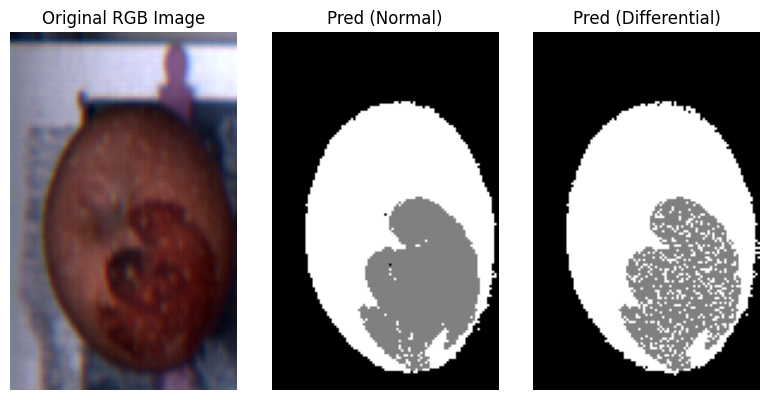

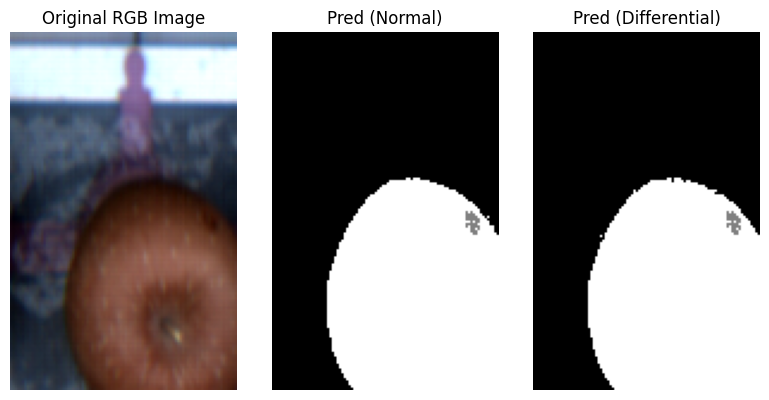

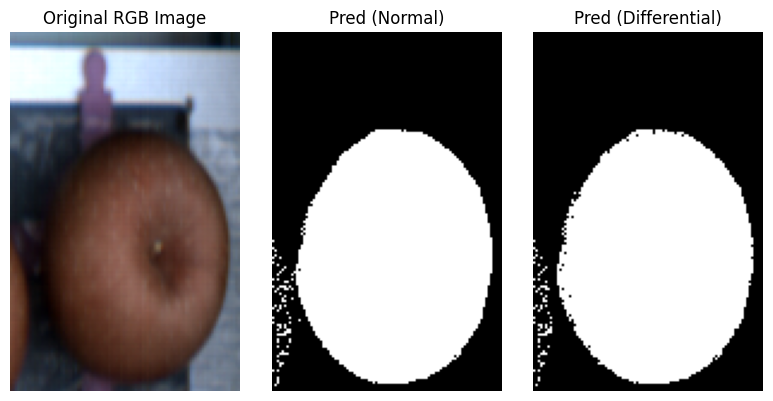

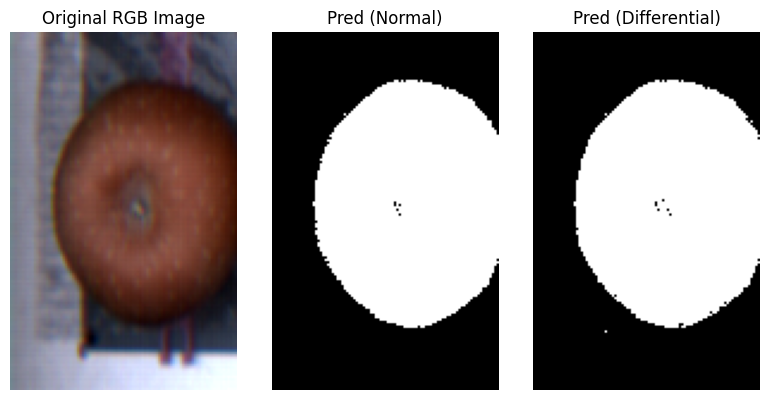

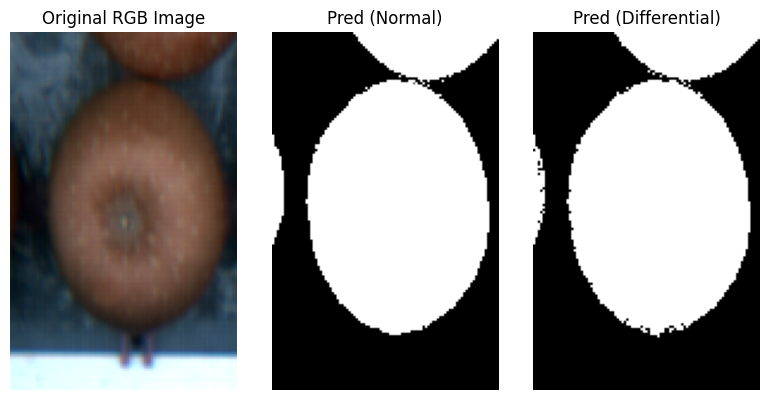

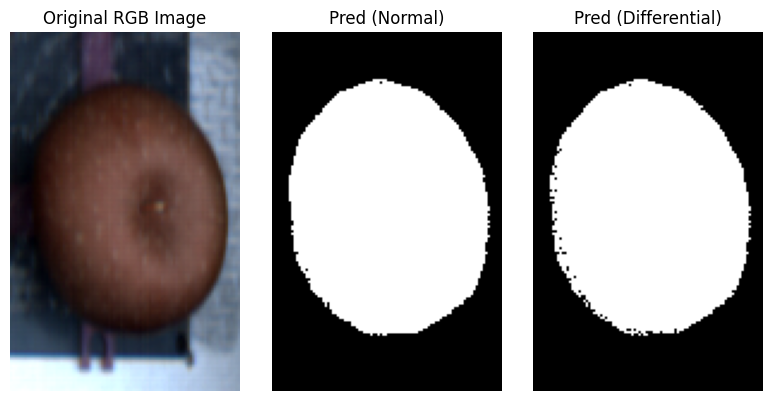

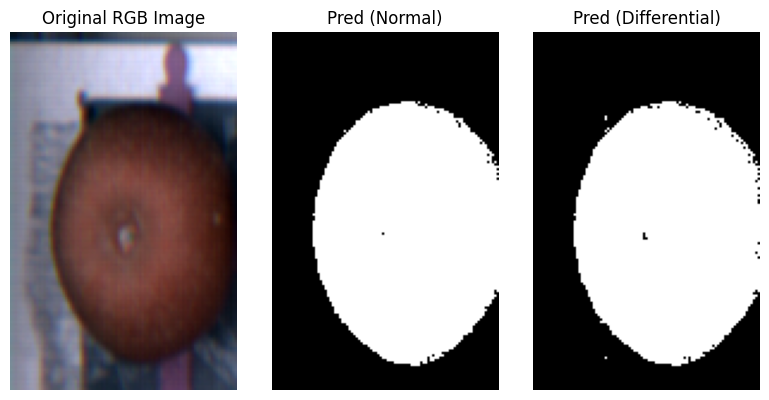

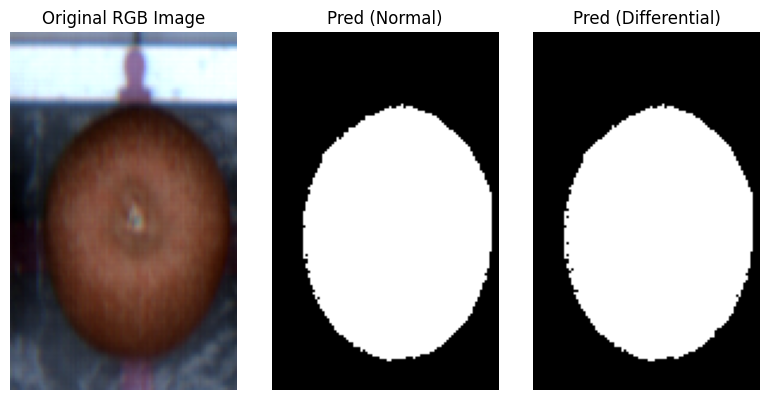

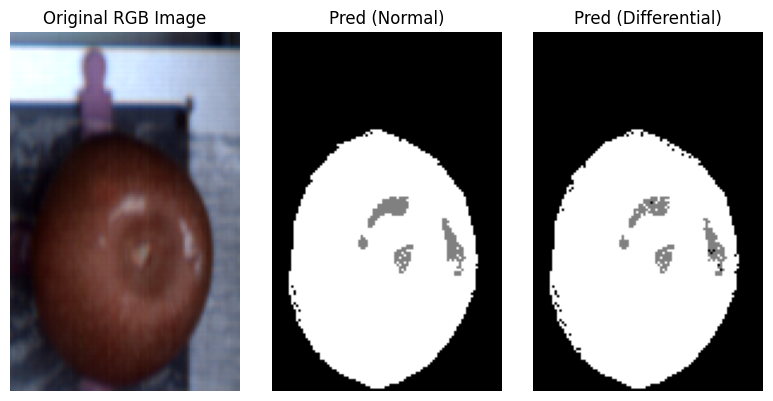

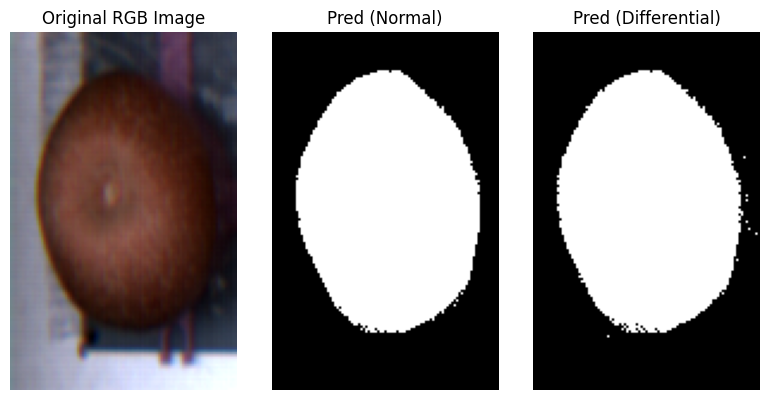

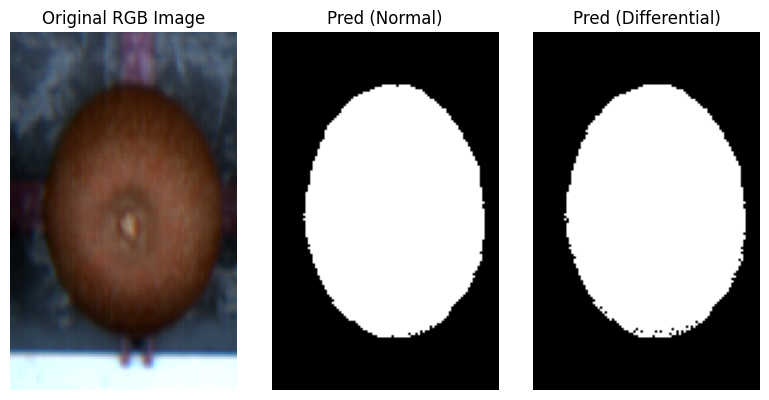

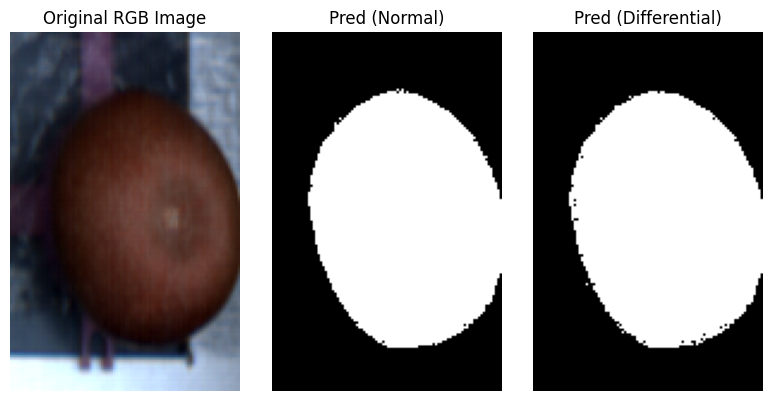

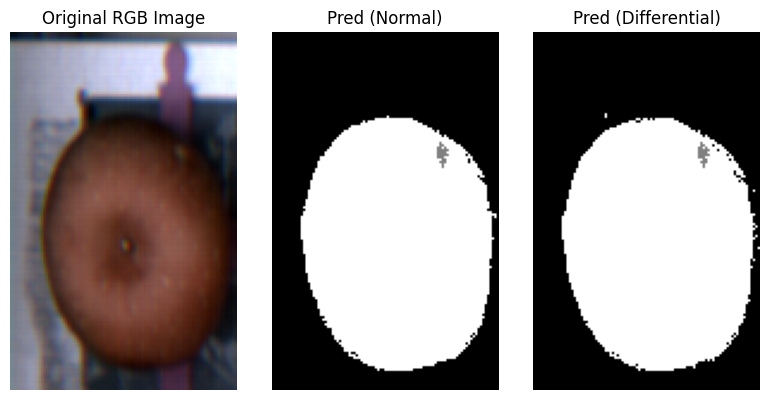

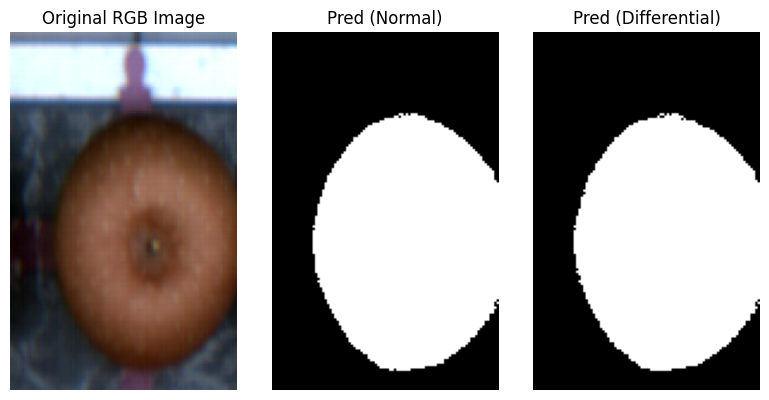

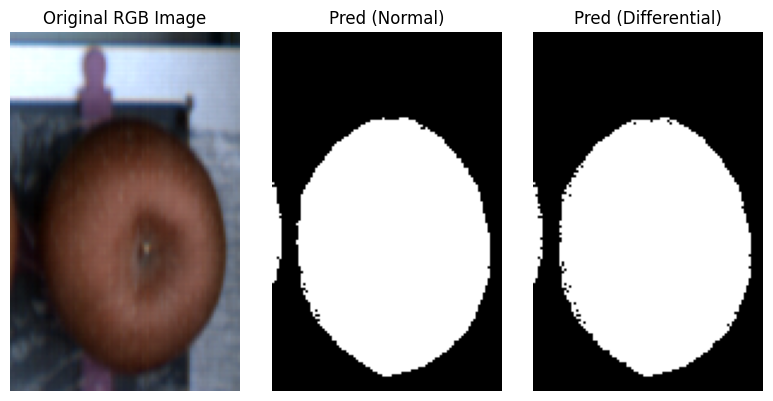

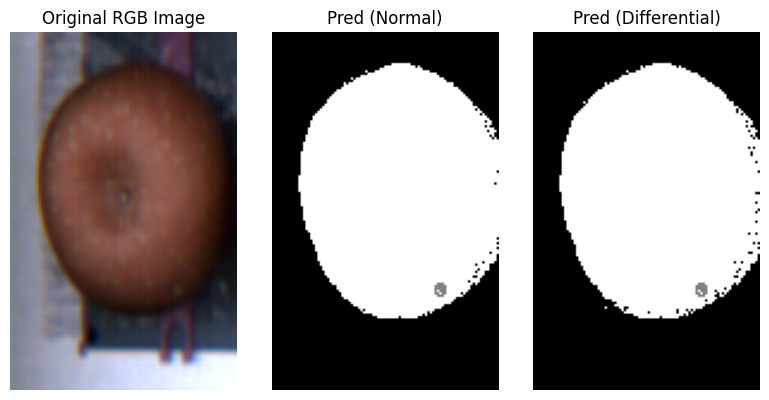

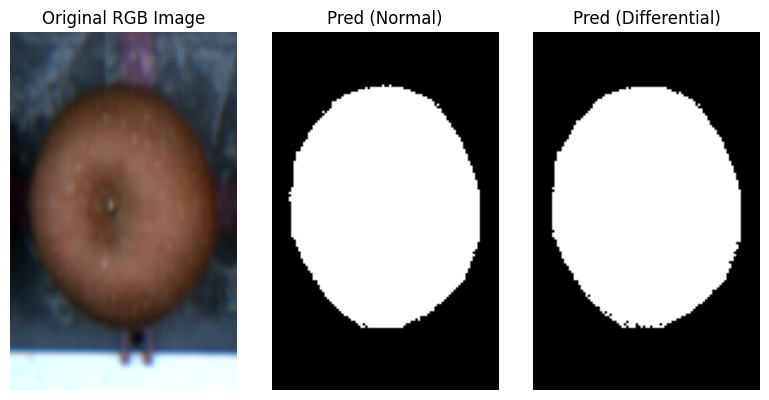

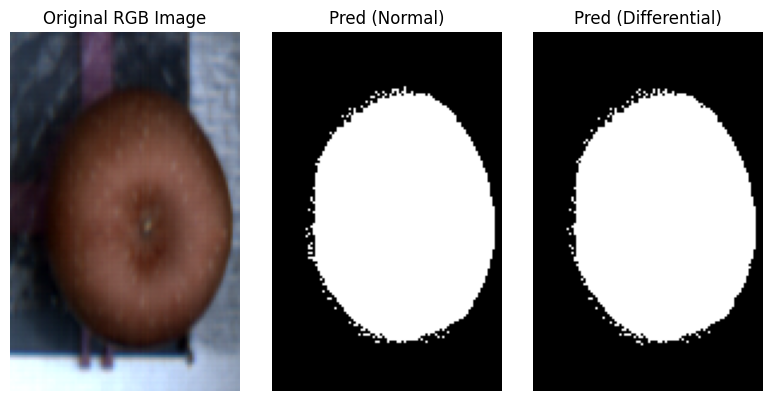

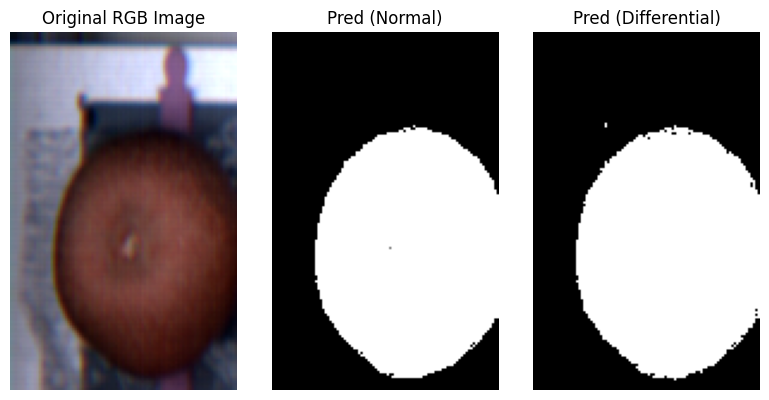

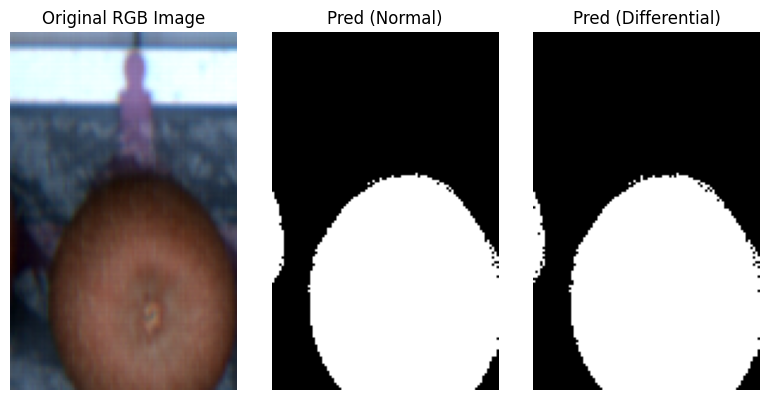

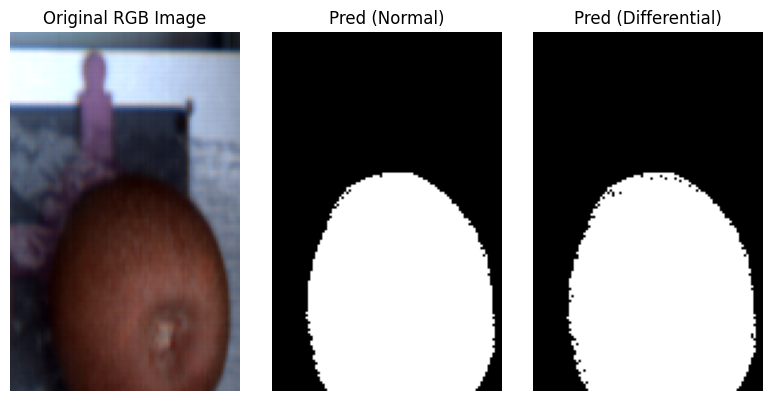

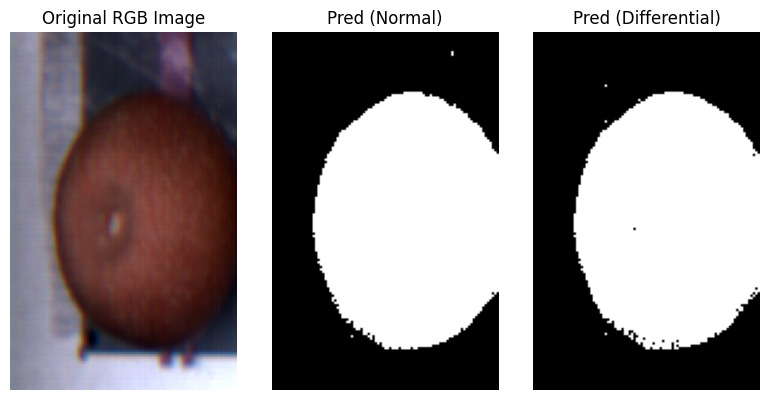

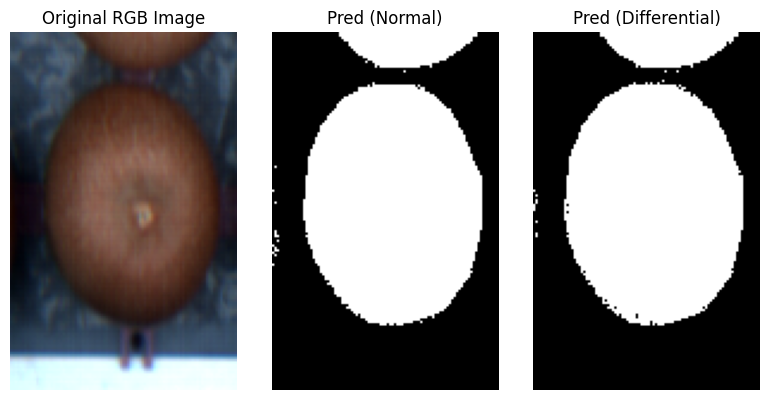

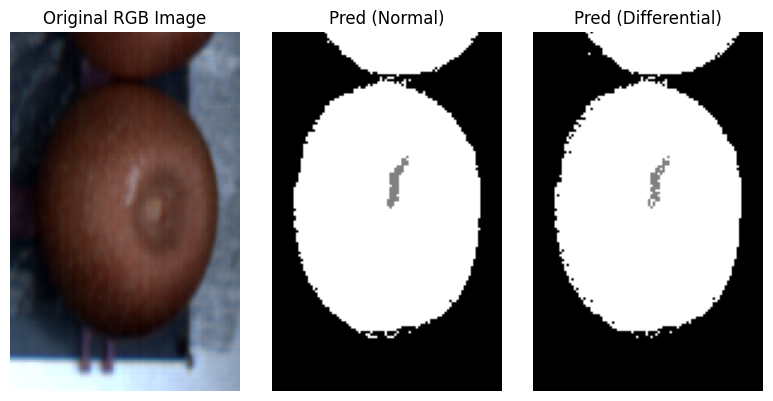

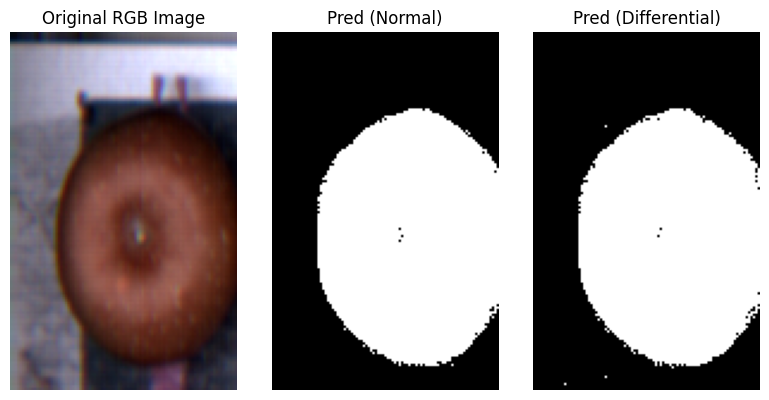

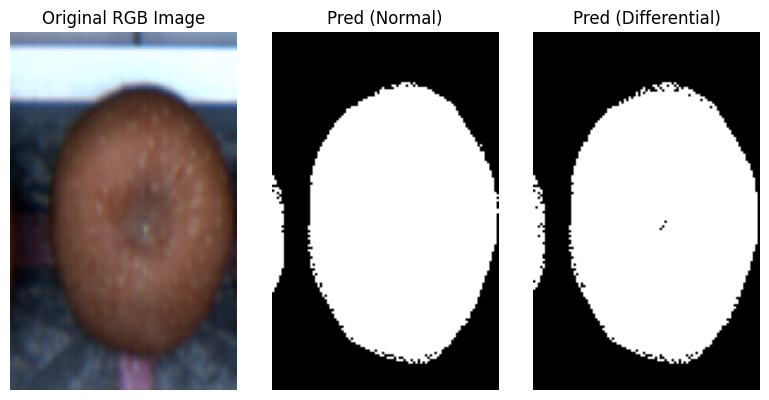

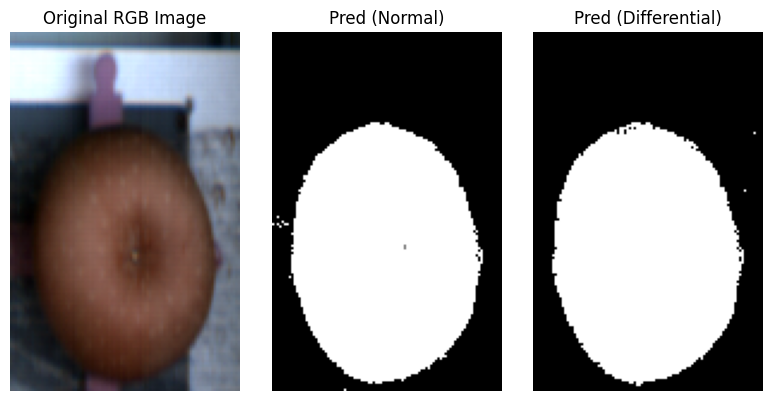

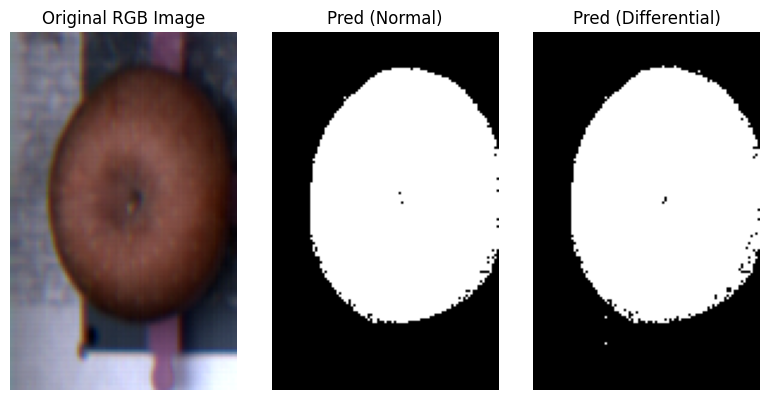

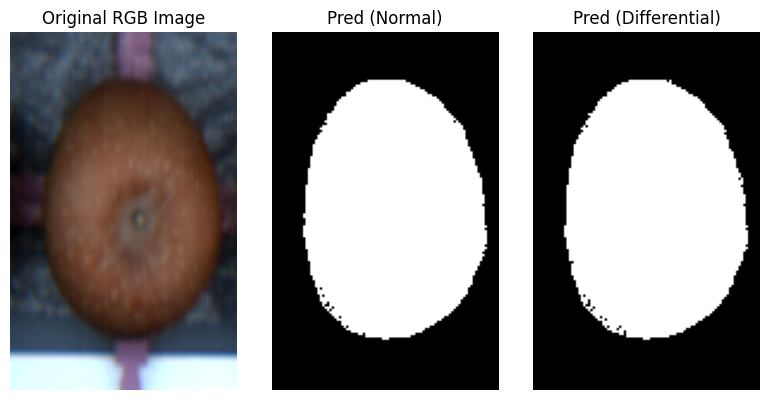

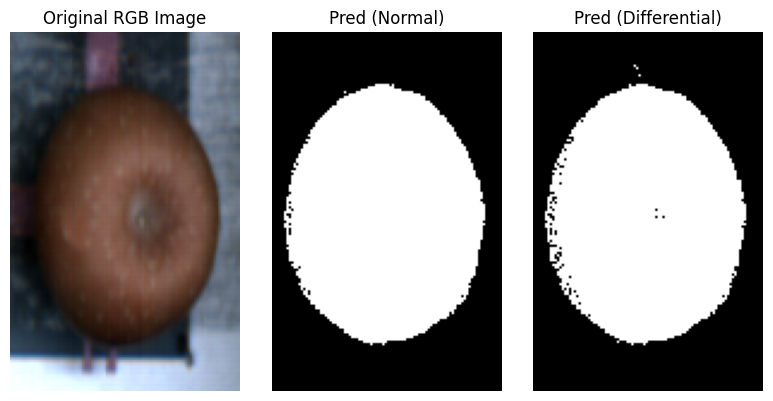

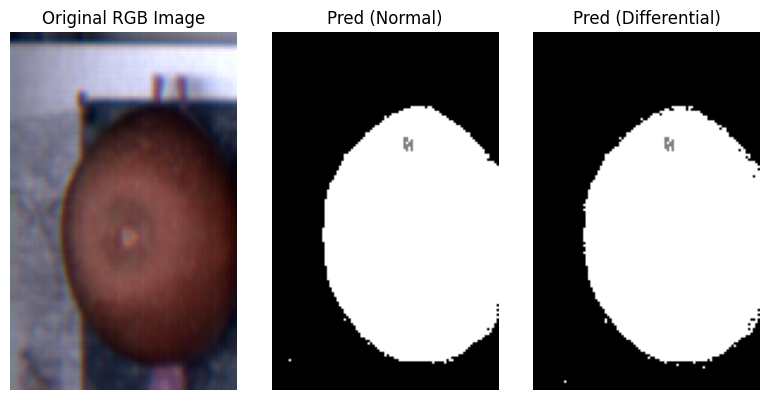

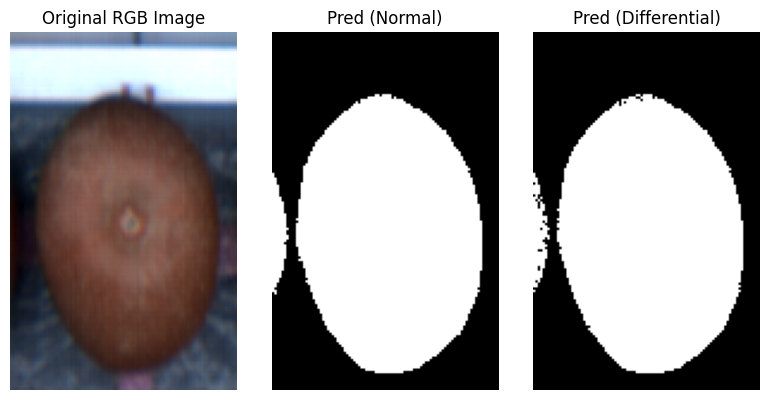

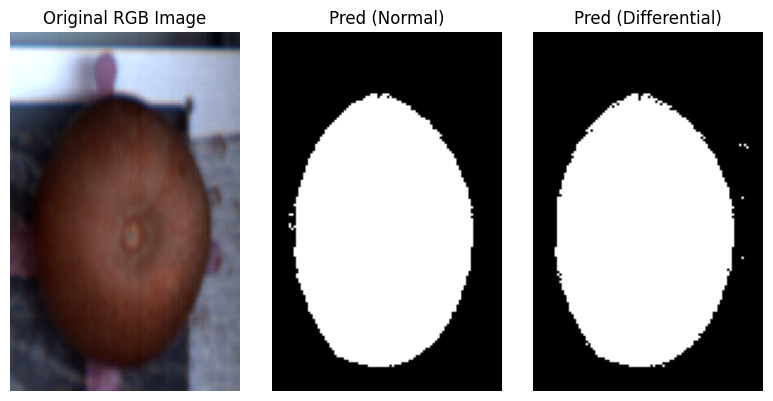

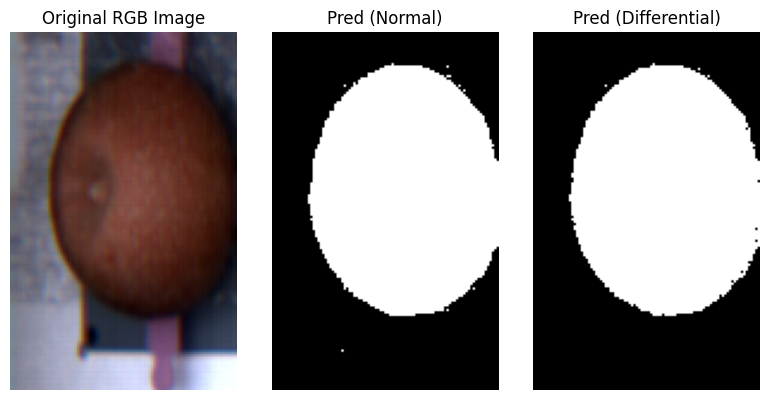

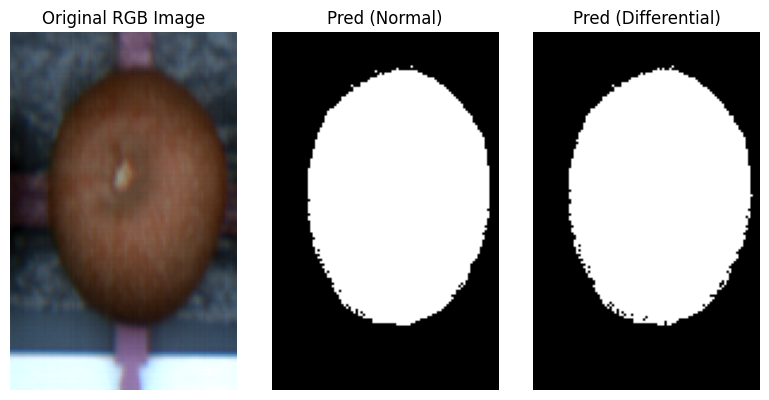

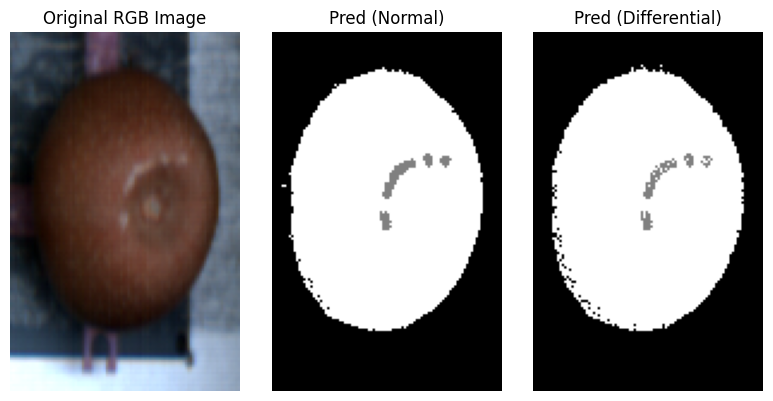

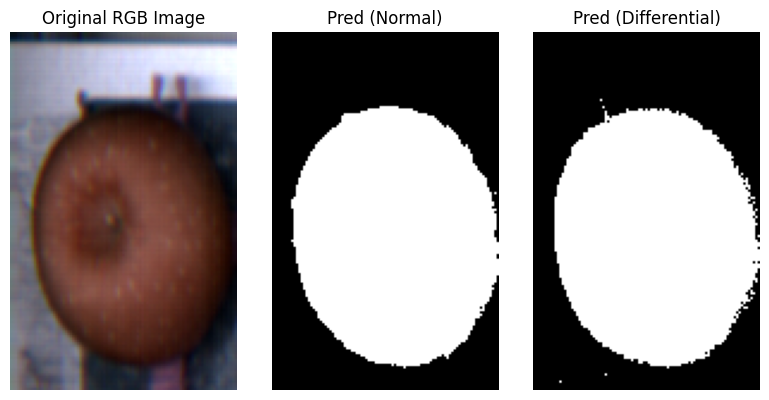

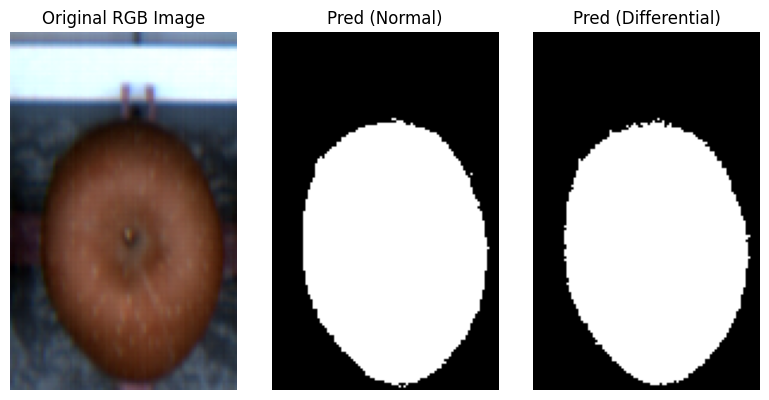

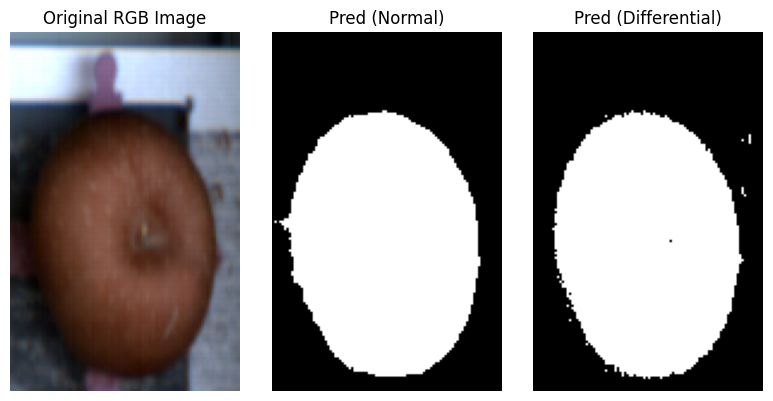

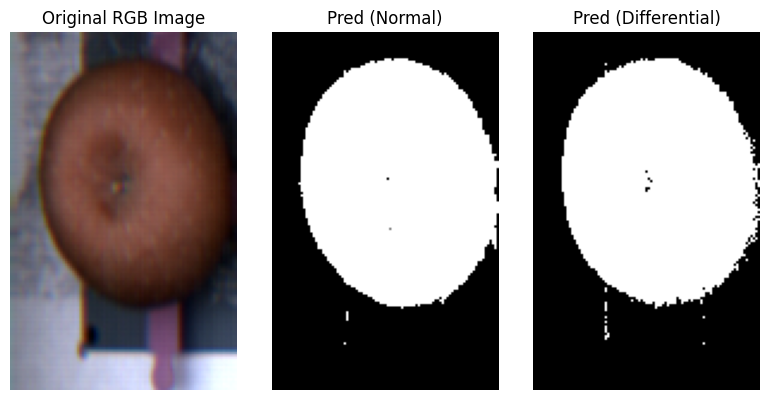

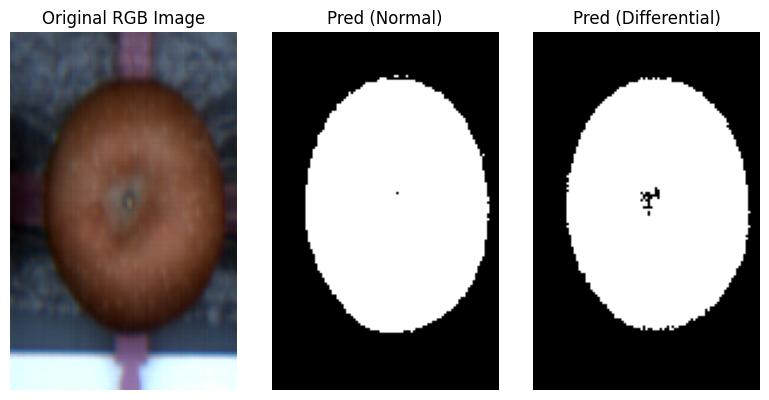

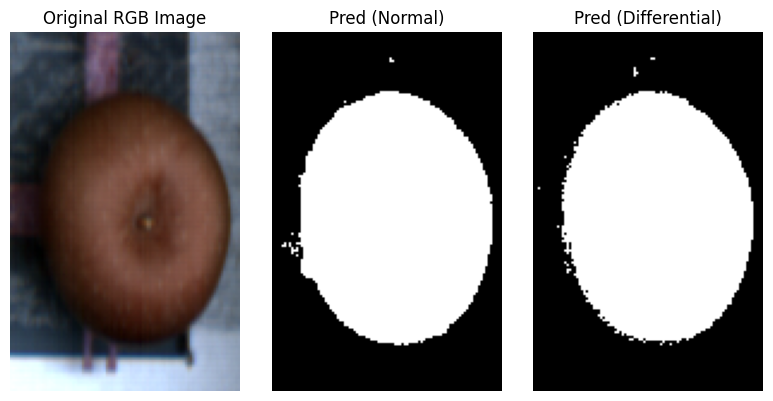

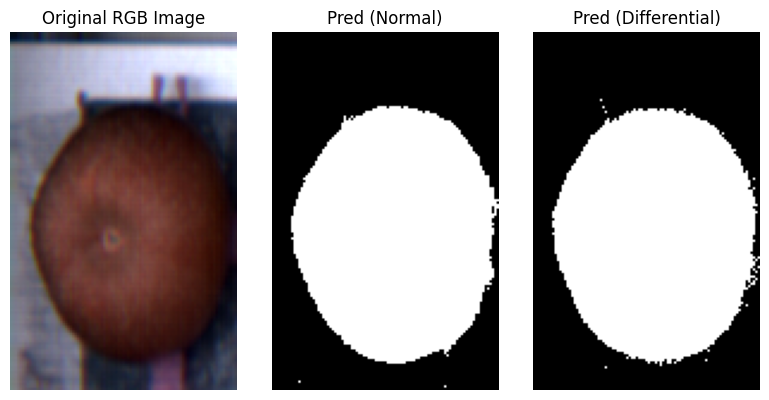

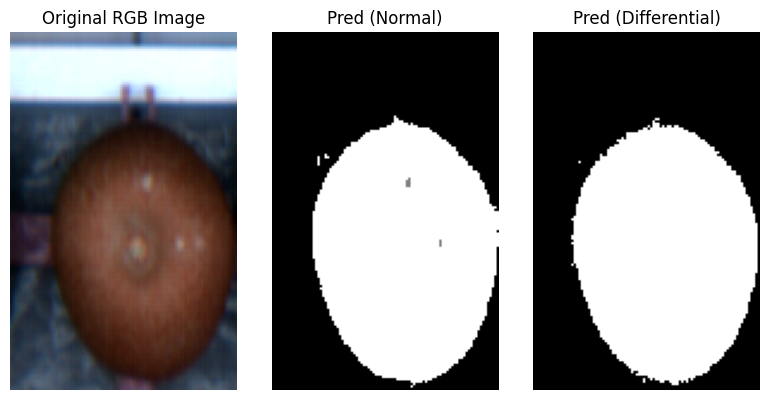

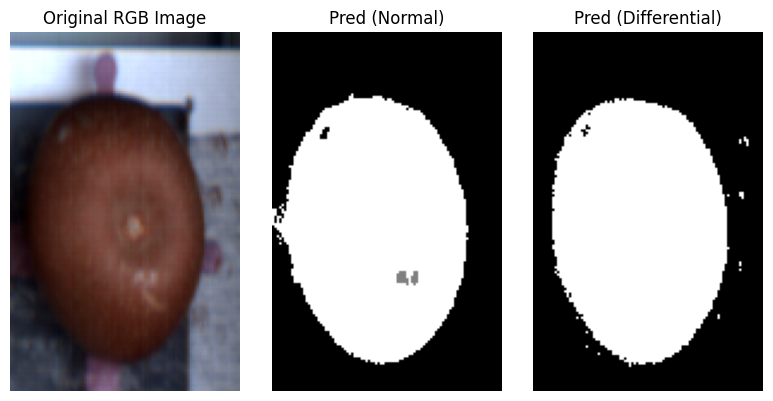

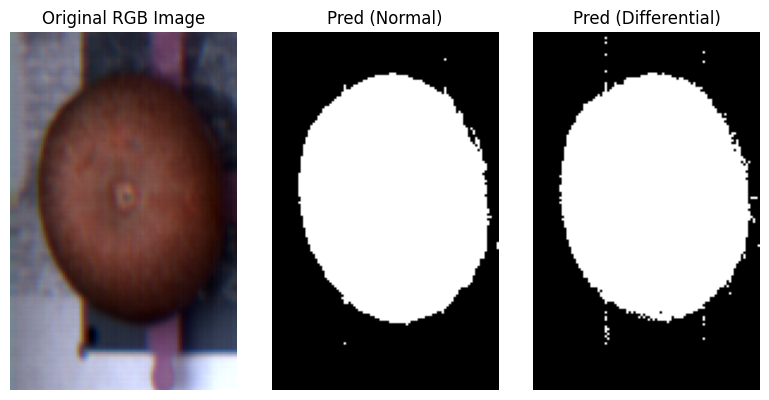

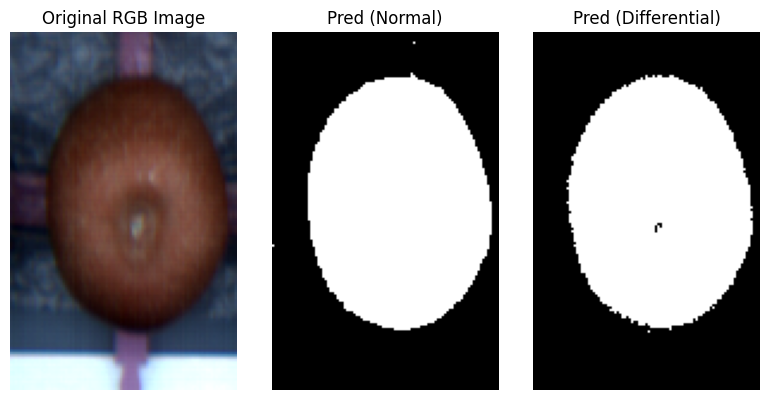

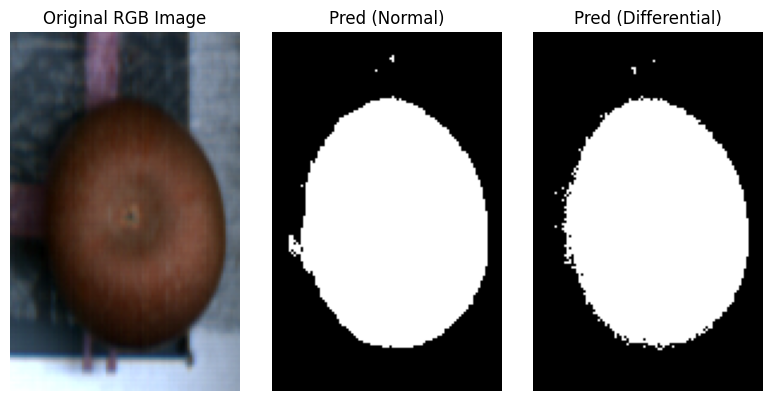

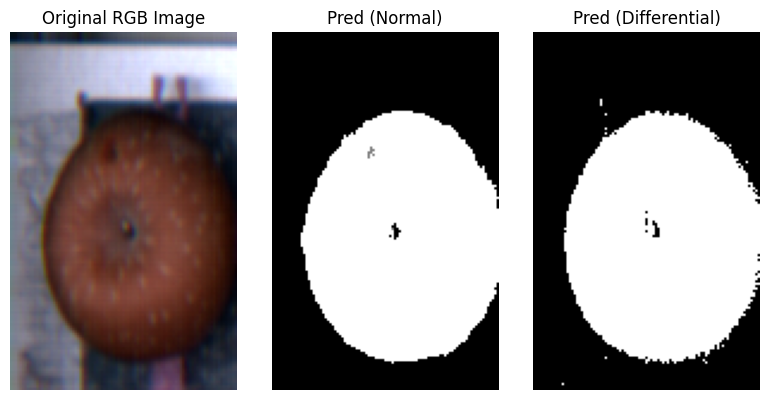

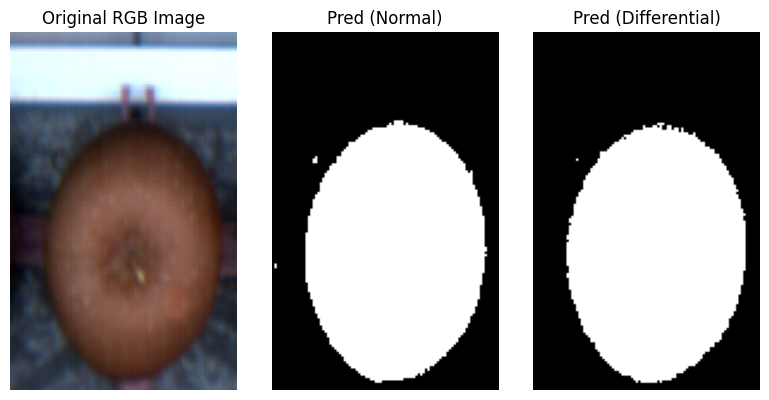

In [28]:
# Example folder and visualization
example_folder = r"C:\\Users\\Jaehyuk\\Desktop\\2024 자체 구축 데이터셋\\사과\\241205 사과 당도\\splited"
visualize_multiple(example_folder, rf_model, rf_model_diff, max_files=50)
